# Temps de trajet aux structures DGFIP

## Imports

In [2]:
import routingpy
import geopandas as gpd
from shapely.geometry import Polygon
client = routingpy.routers.Valhalla(base_url='http://localhost:8002')

In [3]:
bretagne = gpd.read_file('https://github.com/gregoiredavid/france-geojson/raw/master/regions/bretagne/arrondissements-bretagne.geojson')

In [4]:
import pandas as pd
structures = pd.read_csv('https://data.economie.gouv.fr/explore/dataset/coordonnees-des-structures-dgfip/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B',sep=";")

In [5]:
structures = structures[(structures['TYPE DE SERVICE'] == 'Centre de Finances publiques') & structures['DEPARTEMENT'].isin({'22', '29','35','56'})]

## Calcul de l'ischrone à 15 minutes

In [6]:
isochrones = []
for location in  structures.geocodage.str.split(','):
    if not isinstance(location, float):
        iso = client.isochrones(locations=[float(location[1]), float(location[0])], profile='auto', intervals=[60*15])
        iso_df = gpd.GeoDataFrame(
                                {"id": [x for x in range(len(iso))]},
                                geometry=[Polygon(X.geometry) for X in reversed(iso)], crs="EPSG:4326",
                                    )
        isochrones.append(iso_df)
isos = gpd.GeoDataFrame(pd.concat(isochrones, ignore_index=True), crs=4326)

Text(0.5, 1.0, "Zones à moins de 15 minutes en voiture d'une structure DGFIP")

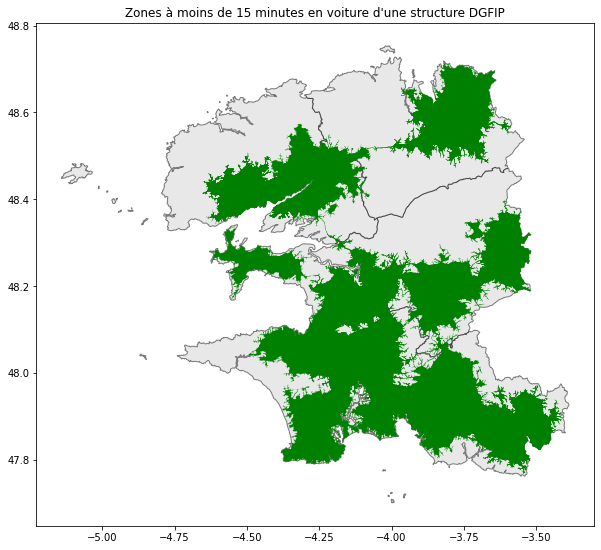

In [7]:
finistere = bretagne[bretagne.code.str.slice(0,2)=='29']
ax = finistere.plot(alpha = 0.5,edgecolor='black', facecolor='lightgrey', figsize = (10,10))
isos.clip(finistere).plot(ax=ax, color='green', legend=True)
ax.set_title("Zones à moins de 15 minutes en voiture d'une structure DGFIP")

In [8]:
isos.clip(finistere).to_file('../dgfip/data/isochrones.geojson', driver="GeoJSON")

/home/titouan/projects/OptimisationFiscale/.venv/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Couverture des zones à moins de 15 minutes en voiture ?

In [9]:
coverage = isos.clip(finistere).to_crs('2154').dissolve().area/finistere.to_crs('2154').dissolve().area
float(coverage)

0.49307945914345064